# 19 - 评估因果模型

在绝大多数关于因果关系的材料中，研究人员使用合成数据来检查他们的方法是否有效。就像我们在“当预测失败时”一章中所做的那样，他们在 \\(Y_{0i}\\) 和 \\(Y_{1i}\\) 上生成数据，以便他们可以检查他们的模型是否正确捕获了干预效果 \\(Y_{1i} - Y_{0i}\\)。这对于学术目的来说很好，但在现实世界中，我们没有那么奢侈的待遇。在工业界中应用这些技术时，我们会一次又一次地被问到为什么我们的模型更好，为什么要在生产中替换当前的模型，或者为什么它不会惨遭失败。这非常重要，以至于我无法理解为什么我们没有看到任何解释我们应该如何用真实数据评估因果推理模型的材料。

因此，想要应用因果推理模型的数据科学家很难说服管理层信任他们。他们采用的方法之一是展示理论的合理性以及他们在训练模型时的谨慎程度。不幸的是，在一个以训练-测试分割范式为常态的世界中，这么做没有什么用。你的模型的质量必须建立在比漂亮的理论更具体的东西上。想想看，机器学习之所以取得巨大成功，是因为预测模型的验证非常直接。看到预测与实际发生的情况相符，这让人放心。

不幸的是，在因果推理的情况下，我们如何实现像训练-测试范式这样的东西并不明显。这是因为因果推理对估计一个不可观察的量感兴趣，\\(\frac{\delta y}{ \delta t}\\)。好吧，如果我们看不到它，我们怎么知道我们的模型是否擅长估计它呢？请记住，就好像每个实体都有潜在的，用从干预到结果的估计线的斜率表示的反应，但我们无法衡量它。

![img](./data/img/evaluate-causal-models/sneak.png)

这是一件非常非常非常困难的事情，我花了很多年才找到接近答案的东西。不是一个确定的模型，但它在实践中有效，并且很具体，我希望它能够从类似于机器学习的训练-测试范式中进行因果推理。诀窍是使用弹性的聚合测量。即使你不能单独估计弹性，你也可以为一个群体做，这就是我们将在这里利用的。

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from toolz import curry

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor

在本章中，我们将使用非随机数据来估计我们的因果模型，并使用随机数据来评估它。 同样，我们将讨论价格如何影响冰淇淋销售。 正如我们将看到的，随机数据对于评估目的非常有价值。 然而，在现实生活中，收集随机数据通常是昂贵的（如果你知道其中一些价格不是很好，只会让你赔钱，为什么还要随机定价？？？）。 最终发生的情况是，我们经常拥有大量数据，其中处理**不是**随机的，而随机数据（如果有的话）非常少。 由于使用非随机数据评估模型非常棘手，因此如果我们有任何随机数据，我们倾向于将其留作评估目的。

以防万一您忘记了，这是数据的样子。

In [2]:
prices = pd.read_csv("./data/ice_cream_sales.csv") # loads non-random data
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv") # loads random data
print(prices_rnd.shape)
prices.head()

(5000, 5)


,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


出于比较目的，让我们训练两个模型。 第一个将是具有交互项的线性回归，以便允许弹性在单位之间变化。

$$
sales_i = \beta_0 + \beta_1 price_i + \pmb{\beta_2 X}_i + \pmb{\beta_3 X}_i price_i + e_i
$$

一旦我们拟合了这个模型，我们将能够进行弹性预测。

$$
\widehat{\frac{\delta sales}{ \delta price}} = \hat{\beta_1} + \pmb{\hat{\beta_3} X}_i
$$

In [3]:
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()

第二个模型将是完全非参数、基于机器学习的预测模型：

$$
sales_i = G(X_i, price_i) + e_i
$$

In [4]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"

np.random.seed(1)
m2 = GradientBoostingRegressor()
m2.fit(prices[X], prices[y]);

为了确保模型没有严重过度拟合，我们可以比较我们使用训练它的数据的到的\\(R^2\\)和使用新的、看不见的数据得到的 \\(R^2\\)。 （对于那些更精通机器学习的人，请注意性能会有所下降，因为存在概念漂移。模型是在价格不是随机的数据中训练的，但测试集只有随机价格）。

In [5]:
print("Train Score:", m2.score(prices[X], prices[y]))
print("Test Score:", m2.score(prices_rnd[X], prices_rnd[y]))

Train Score: 0.9251704824568053
Test Score: 0.7711074163447711


在训练我们的模型之后，我们将从回归模型中获得弹性。 同样，我们将求助于数值近似

$$
\frac{\delta y(t)}{\delta t} \approx \frac{y(t+h) - y(t)}{h}
$$

我们的模型接受了非随机数据的训练。 现在我们转向随机数据进行预测。 就这样我们将所有东西都放在一个地方，我们将把机器学习模型的预测和因果模型的弹性预测添加到单个数据帧“prices_rnd_pred”中。

此外，我们还包括一个随机模型。 这个想法是这个模型只输出随机数作为预测。 它显然不是很有用，但它可以很好地作为基准。 每当我们谈论进行评估的新方法时，我总是喜欢思考随机（无用）模型会如何做。 如果随机模型能够在评估标准上表现良好，那就说明评估方法的真正好坏。

In [6]:
def predict_elast(model, price_df, h=0.01):
    return (model.predict(price_df.assign(price=price_df["price"]+h))
            - model.predict(price_df)) / h

np.random.seed(123)
prices_rnd_pred = prices_rnd.assign(**{
    "m1_pred": m2.predict(prices_rnd[X]), ## predictive model
    "m2_pred": predict_elast(m1, prices_rnd), ## elasticity model
    "m3_pred": np.random.uniform(size=prices_rnd.shape[0]), ## random model
})

prices_rnd_pred.head()

,temp,weekday,cost,price,sales,m1_pred,m2_pred,m3_pred
0,25.8,1,0.3,7,230,224.067406,-13.096964,0.696469
1,22.7,3,0.5,4,190,189.889147,1.054695,0.286139
2,33.7,7,1.0,5,237,237.255157,-17.362642,0.226851
3,23.0,4,0.5,5,193,186.688619,0.564985,0.551315
4,24.4,1,1.0,3,252,250.342203,-13.717946,0.719469


## 弹性模型带

现在我们有了预测，我们需要评估它们的好坏。请记住，我们无法观察到弹性，因此没有可以比较的简单基本事实。相反，让我们回想一下我们想要从弹性模型中得到什么。也许这会给我们一些关于如何评估它们的见解。

制作干预弹性模型的想法来自于需要找出哪些单位对干预更敏感，哪些更不敏感。它来自对个性化的渴望。也许营销活动只在一部分人群中非常有效。也许折扣只适用于某些类型的客户。一个好的因果模型应该可以帮助我们发现哪些客户对提议的干预反应更好和更差。他们应该能够将单位分成他们对干预的弹性或敏感程度。在我们的冰淇淋示例中，该模型应该能够计算出人们在哪几天愿意在冰淇淋上花费更多，或者在哪几天价格弹性的负值较小。

如果这是目标，那么如果我们能以某种方式将单位从更敏感到不太敏感排序，那将非常有用。由于我们有预测的弹性，我们可以按该预测对单位进行排序，并希望它也按实际弹性对它们进行排序。遗憾的是，我们无法在单位级别上评估该排序。但是，如果我们不需要呢？相反，如果我们评估由排序定义的组怎么办？如果我们的处理是随机分布的（这是随机性进入的地方），那么估计一组单​​位的弹性很容易。我们所需要的只是比较干预与否的结果。

为了更好地理解这一点，描绘二元处理案例很有用。让我们保留定价示例，但现在的干预量是折扣。换句话说，价格可以高（未处理）或低（处理）。让我们在 Y 轴上绘制销售额，在 X 轴上绘制我们的每个模型，并将价格作为颜色。然后，我们可以将模型轴上的数据分成三个大小相等的组。 **如果干预是随机分配的**，我们可以轻松估计每组的 ATE \\(E[Y|T=1] - E[Y|T=0]
\\)。

![img](./data/img/evaluate-causal-models/ate_bins.png)

在图像中，我们可以看到第一个模型在预测销售额方面有些好（与销售额相关性高），但它产生的组具有大致相同的处理效果，如下图所示。三个部分中有两个具有相同的弹性，只有最后一个具有不同的较低弹性。

另一方面，第二个模型产生的每一组都有不同的因果效应。这表明该模型确实可以用于个性化。最后，随机模型产生具有完全相同弹性的组。这不是很有用，但它是预期的。如果模型是随机的，则它产生的每个片段都是随机且具有代表性的数据样本。因此，其组中的弹性应该与整个数据集上的 ATE 大致相同。

只需查看这些图，您就可以了解哪个模型更好。弹性看起来越有序，带之间的差异越大，越好。在这里，模型 2 可能比模型 1 更好，这可能比随机模型更好。

为了将其推广到连续情况，我们可以使用单变量线性回归模型来估计弹性。

$$
y_i = \beta_0 + \beta_1t_i + e_i
$$

如果我们使用一组样本运行该模型，我们将估计该组内的弹性。

根据简单线性回归的理论，我们知道

$$
\hat{\beta_1}=\dfrac{\sum (t_i - \bar{t}) (y_i - \bar{y})}{\sum(t_i - \bar{t})^2}
$$

其中 \\(\bar{t}\\) 是处理的样本平均值，\\(\bar{y}\\) 是结果的样本平均值。 这是代码中的样子

In [7]:
@curry
def elast(data, y, t):
        # line coeficient for the one variable linear regression 
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

现在让我们将其应用于我们的冰淇淋价格数据。 为此，我们还需要一个函数，将数据集分割成大小相等的分区，并将弹性应用于每个分区。 以下代码将处理该问题。

In [8]:
def elast_by_band(df, pred, y, t, bands=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=bands)}) # makes quantile partitions
            .groupby(f"{pred}_band")
            .apply(elast(y=y, t=t))) # estimate the elasticity on each partition

最后，让我们使用我们之前所做的预测按波段绘制弹性。 在这里，我们将使用每个模型来构建分区，然后估计每个分区的弹性。

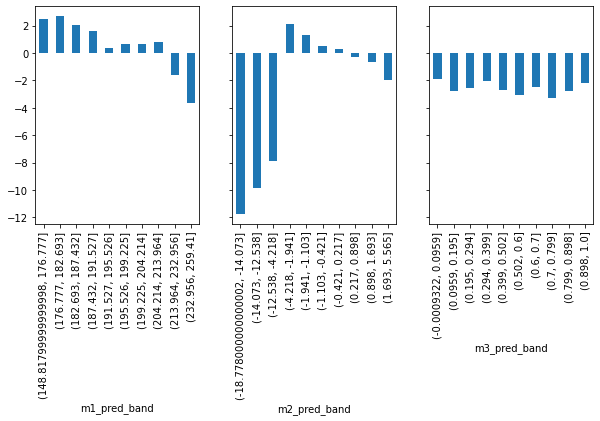

In [9]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
for m, ax in enumerate(axs):
    elast_by_band(prices_rnd_pred, f"m{m+1}_pred", "sales", "price").plot.bar(ax=ax)


首先，查看随机模型 (\\(m3\\))。它在每个分区中具有大致相同的估计弹性。通过查看该图，我们已经可以看出，它对个性化没有太大帮助，因为它无法区分高价格弹性日和低价格弹性日。接下来，考虑预测模型 \\(m1\\)。该模型实际上是有前途的！它设法构建弹性高的组和弹性低的组。这正是我们所需要的。

最后，因果模型 \\(m2\\) 看起来有点奇怪。它识别出弹性非常低的群体，这里的低实际上意味着高价格敏感度（随着我们提高价格，销售额将大幅下降）。检测那些价格敏感的日子对我们非常有用。如果我们知道它们是什么时候，我们会小心不要在这些日子继续涨价。因果模型还识别了一些不太敏感的区域，因此它可以成功地区分高弹性和低弹性。但是排序不如预测模型好。

那么，我们应该如何决定呢？哪个更有用？预测模型还是因果模型？预测模型具有更好的排序，但因果模型可以更好地识别极端情况。带状图的弹性是一个很好的初步检查，但它不能准确回答哪个模型更好。我们需要转向更精细的东西。

## 累积弹性曲线

再次考虑将价格转换为二元处理的说明性示例。我们会从我们离开的地方拿走它，所以我们有弹性处理带。我们接下来可以做的是根据乐队的敏感程度对乐队进行排序。也就是说，我们把最敏感的组放在第一位，第二个最敏感的组放在第二位，依此类推。对于模型 1 和 3，无需重新订购，因为它们已经订购。对于模型 2，我们必须颠倒排序。

一旦我们有了有序的组，我们就可以构建我们称之为累积弹性曲线的东西。我们首先计算第一组的弹性；然后，第一个和第二个等等，直到我们包含所有组。最后，我们将只计算整个数据集的弹性。这是我们的说明性示例的外观。

![img](./data/img/evaluate-causal-models/cumm_elast.png)

请注意，累积弹性中的第一个 bin 只是根据该模型来自最敏感组的 ATE。此外，对于所有模型，累积弹性将收敛到同一点，即整个数据集的 ATE。

在数学上，我们可以将累积弹性定义为直到单位 \\(k\\) 之前估计的弹性。

$$
\widehat{y'(t)}_k = \hat{\beta_1}_k=\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k (t_i - \bar{t})^2}
$$

为了构建累积弹性曲线，我们在数据集中迭代地运行上述函数以产生以下序列。

$$
(\widehat{y'(t)}_1, \widehat{y'(t)}_2, \widehat{y'(t)}_3,..., \widehat{y'(t)}_N)
$$

就模型评估而言，这是一个非常有趣的序列，因为我们可以对其进行偏好陈述。首先，模型更好的程度

$\hat{y}'(t)_k > \hat{y}'(t)_{k+a}$

对于任何 \\(k\\) 和 \\(a>0\\)。换句话说，如果一个模型擅长对弹性进行排序，那么在前 \\(k\\) 个样本中观察到的弹性应该高于在前 \\(k+a\\) 个样本中观察到的弹性。或者，简单地说，如果我查看顶部单位，它们应该比它们下面的单位具有更高的弹性。

其次，模型更好的程度

$\hat{y}'(t)_k - \hat{y}'(t)_{k+a}$

是最大的，对于任何 \\(k\\) 和 \\(a>0\\)。直觉是，我们不仅希望顶部 \\(k\\) 单位的弹性高于其下方单位的弹性，而且我们希望这种差异尽可能大。

为了使其更具体，这是用代码表示的这个想法。

In [10]:
def cumulative_elast_curve(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    
    # orders the dataset by the `prediction` column
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    # create a sequence of row numbers that will define our Ks
    # The last item is the sequence is all the rows (the size of the dataset)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # cumulative computes the elasticity. First for the top min_periods units.
    # then for the top (min_periods + step*1), then (min_periods + step*2) and so on
    return np.array([elast(ordered_df.head(rows), y, t) for rows in n_rows])

关于此功能的一些注意事项。 它假定对弹性进行排序的事物存储在传递给“预测”参数的列中。 此外，第一组有 `min_periods` 单位，因此它可以与其他组不同。 原因是，由于样本量小，弹性在曲线开始时可能过于嘈杂。 为了解决这个问题，我们可以传递一个已经足够大的第一组。 最后，`steps` 参数定义了我们在每个后续组中包含多少额外单元。

使用此功能，我们现在可以根据每个模型产生的顺序绘制累积弹性曲线。

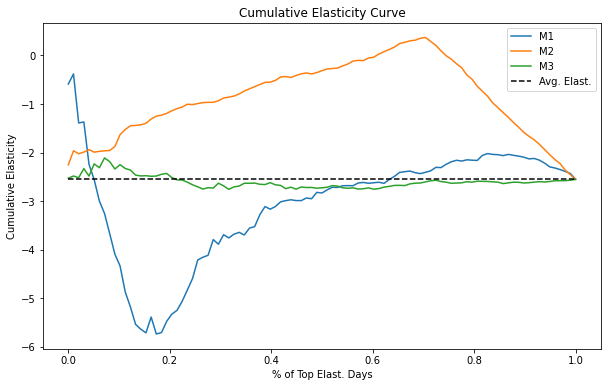

In [11]:
plt.figure(figsize=(10,6))

for m in range(3):
    cumu_elast = cumulative_elast_curve(prices_rnd_pred, f"m{m+1}_pred", "sales", "price", min_periods=100, steps=100)
    x = np.array(range(len(cumu_elast)))
    plt.plot(x/x.max(), cumu_elast, label=f"M{m+1}")

plt.hlines(elast(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")
plt.xlabel("% of Top Elast. Days")
plt.ylabel("Cumulative Elasticity")
plt.title("Cumulative Elasticity Curve")
plt.legend();

解释累积弹性曲线可能有点挑战性，但这是我的看法。同样，考虑二分类情况可能更容易。曲线的 X 轴代表我们正在处理的样本数量。在这里，我将轴归一化为数据集的比例，所以 0.4 意味着我们正在处理 40% 的样本。 Y 轴是我们在这么多样本上应该预期的弹性。因此，如果一条曲线在 40% 处的值为 -1，则意味着前 40% 单位的弹性为 -1。理想情况下，我们希望尽可能大的样本具有最高的弹性。理想的曲线将在 Y 轴上从高处开始，然后非常缓慢地下降到平均弹性，这表示我们可以处理高百分比的单位，同时仍保持高于平均弹性。

不用说，我们的模型都没有接近理想的弹性曲线。随机模型 \\(M3\\) 围绕平均弹性波动，并且永远不会离它太远。这意味着该模型无法找到弹性与平均弹性不同的组。至于预测模型 \\(M1\\)，它似乎是反向排序的弹性，因为曲线从低于平均弹性开始。不仅如此，它还在大约 50% 的样本处很快收敛到平均弹性。最后，因果模型 \\(M2\\) 似乎更有趣。一开始它有这种奇怪的行为，累积弹性增加远离平均值，但随后它达到了一个点，我们可以处理大约 75% 的单位，同时保持几乎为 0 的相当不错的弹性。这可能是因为这个模型可以识别非常低弹性（高价格敏感度）的日子。因此，如果我们在那些日子不提价，我们可以对大部分样本（约 75%）进行提价，同时价格敏感度仍然较低。

在模型评估方面，累积弹性曲线（Cumulative Elasticity Curve） 已经远远好于简单的分区间的弹性概念。在这里，我们设法对我们的模型做出更精确的偏好陈述。不过，这是一条复杂的曲线，难以理解。出于这个原因，我们可以做进一步的改进。

## 累积增益曲线

下一个想法是在累积弹性之上进行非常简单但强大的改进。我们将累积弹性乘以比例样本量。例如，如果累积弹性在 40% 时为 -0.5，那么此时我们将得到 -0.2 (-0.5 * 0.4)。然后，我们将其与随机模型产生的理论曲线进行比较。这条曲线实际上是一条从 0 到平均干预效果的直线。可以这样想：随机模型的累积弹性中的每个点都是 ATE，因为该模型只生成数据的随机代表性分区。如果在 (0,1) 线上的每一点，我们将 ATE 乘以该点，我们最终会得到一条介于 0 和 ATE 之间的直线。

![img](./data/img/evaluate-causal-models/cumm_gain.png)

一旦我们有了理论上的随机曲线，我们就可以将其用作基准，并将我们的其他模型与它进行比较。所有曲线将在同一点开始和结束。然而，模型的弹性排序越好，曲线在零到一之间的点处偏离随机线的程度就越大。例如，在上图中，M2 优于 M1，因为它在到达终点 ATE 之前发散得更多。对于熟悉 ROC 曲线的人，您可以将累积增益视为因果模型的 ROC。

从数学上讲，

$$
\widehat{F(t)}_k = \hat{\beta_1}_k * \frac{k}{N} =\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y })}{\sum_i^k(t_i - \bar{t})^2} * \frac{k}{N}
$$


要在代码中实现它，我们所要做的就是添加比例样本大小归一化。

In [12]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    ## add (rows/size) as a normalizer. 
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

使用我们的冰激凌数据，我们会得到如下曲线。

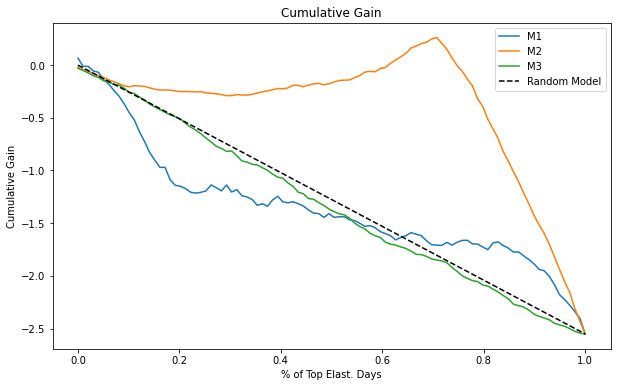

In [13]:
plt.figure(figsize=(10,6))

for m in range(3):
    cumu_gain = cumulative_gain(prices_rnd_pred, f"m{m+1}_pred", "sales", "price", min_periods=50, steps=100)
    x = np.array(range(len(cumu_gain)))
    plt.plot(x/x.max(), cumu_gain, label=f"M{m+1}")
    
plt.plot([0, 1], [0, elast(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain")
plt.legend();

现在很清楚，因果模型（M2）比其他两个要好得多。它与随机线的差异远大于 M1 和 M3。此外，请注意随机模型 M3 如何非常接近理论随机模型。两者之间的区别可能只是随机噪声。

有了这个，我们介绍了一些关于如何评估因果模型的非常好的想法。仅此一项就是一件大事。即使我们没有要比较的基本事实，我们也设法评估了模型在排序弹性方面的好坏。只缺少最后一件事，即包括围绕这些测量值的置信区间。毕竟，我们不是野蛮人，不是吗？

![img](./data/img/evaluate-causal-models/uncivilised.png)


## 考虑差异

当我们处理弹性曲线时，不考虑方差是错误的。特别是由于它们都使用线性回归理论，因此在它们周围添加置信区间应该相当容易。

为此，我们将首先创建一个函数，该函数返回线性回归参数的 CI。我在这里使用简单线性回归的公式，但可以随意提取 CI。

$$
s_{\hat\beta_1}=\sqrt{\frac{\sum_i\hat\epsilon_i^2}{(n-2)\sum_i(t_i-\bar t)^2}}
$$

In [14]:
def elast_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = elast(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1*df[t])
    se = np.sqrt(((1/(n-2))*np.sum(e**2))/np.sum((df[t]-t_bar)**2))
    return np.array([beta1 - z*se, beta1 + z*se])

通过对我们的`cumulative_elast_curve`函数进行一些小的修改，我们可以输出弹性的置信区间。

In [15]:
def cumulative_elast_curve_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # just replacing a call to `elast` by a call to `elast_ci`
    return np.array([elast_ci(ordered_df.head(rows), y, t)  for rows in n_rows])

最后，这是因果 (M2) 模型的 95% CI 的累积弹性曲线。

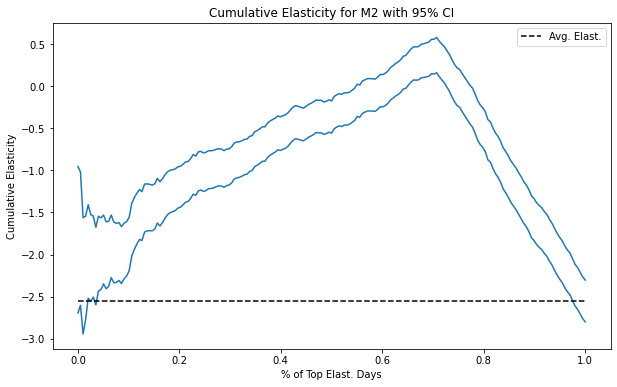

In [16]:
plt.figure(figsize=(10,6))

cumu_gain_ci = cumulative_elast_curve_ci(prices_rnd_pred, "m2_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain_ci)))
plt.plot(x/x.max(), cumu_gain_ci, color="C0")

plt.hlines(elast(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")

plt.xlabel("% of Top Elast. Days")
plt.ylabel("Cumulative Elasticity")
plt.title("Cumulative Elasticity for M2 with 95% CI")
plt.legend();

注意随着我们积累更多的数据集，CI 是如何变得越来越小的。 那是因为样本量增加了。

至于累积增益曲线，获取 CI 也同样简单。 同样，我们只是将调用 `elast` 函数替换为调用 `elast_ci` 函数。

In [17]:
def cumulative_gain_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast_ci(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

这是因果模型的样子。 请注意，现在 CI 开始时很小，即使曲线开始时的样本量较小。 原因是归一化因子 \\(\frac{k}{N}\\) 回避了 ATE 参数，并且它是 CI。 由于这条曲线应该用于比较模型，所以这应该不是问题，因为曲线会将这个推卸因子平等地应用于所有正在评估的模型。

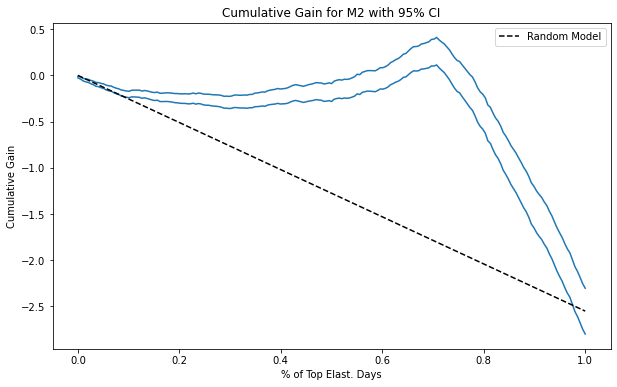

In [18]:
plt.figure(figsize=(10,6))

cumu_gain = cumulative_gain_ci(prices_rnd_pred, "m2_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain)))
plt.plot(x/x.max(), cumu_gain, color="C0")

plt.plot([0, 1], [0, elast(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain for M2 with 95% CI")
plt.legend();

## 关键思想

在这里，我们看到了三种方法来检查模型在排序弹性方面的好坏。我们使用这些方法来比较和决定具有因果关系的模型。这是非常重要的。我们已经设法检查了一个模型是否擅长识别具有不同弹性的组，即使无法看到弹性！

在这里，我们严重依赖随机数据。我们在非随机数据上训练了模型，但所有评估都是在随机处理的样本上完成的。那是因为我们需要某种方法来自信地估计弹性。如果没有随机数据，我们在这里使用的简单公式将不起作用。正如我们现在非常清楚的那样，简单的线性回归在存在混杂变量的情况下忽略了变量偏差。

尽管如此，如果我们能够掌握一些随机数据，我们就已经知道如何比较随机模型了。在下一章中，我们将解决非随机数据的问题，但在开始之前，我最后想说一些关于模型评估的想法。

让我们重申一下可信赖模型评估的重要性。通过累积增益曲线，我们终于有了一种比较用于因果推理的模型的好方法。我们现在可以决定哪种模型更适合个性化干预。这是非常重要的。您会在因果推理中找到的大多数材料都没有为我们提供进行模型评估的好方法。在我看来，这是我们需要让因果推理像机器学习一样流行的缺失部分。通过良好的评估，我们可以使因果推理更接近已经对预测模型非常有用的训练测试范式。这是一个大胆的声明。这意味着我提到这个的时候很小心，但直到现在，我还没有找到任何好的点评。如果你有一些想法，请告诉我。
